In [79]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [80]:
path = 'lfw'

In [81]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [82]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


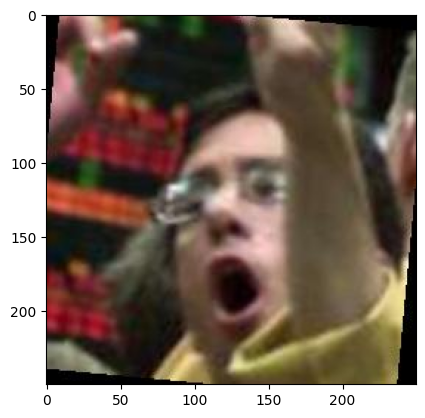

In [83]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

AutoEncoders (AEs) and Variational AutoEncoders (VAEs) are both neural network architectures used for different purposes and have significant differences:

1. **Applications**:
   - **AutoEncoders**: AEs are primarily used for tasks where the accurate representation of input data is crucial. They excel in applications such as data compression, noise reduction, and feature extraction. AEs aim to encode input data into a lower-dimensional latent space while preserving as much information as possible.
   - **Variational AutoEncoders (VAEs)**: VAEs are employed in more creative and generative applications. They are designed to synthesize new data samples that resemble their training datasets. VAEs are commonly used in tasks like image generation, music composition, and text generation. They not only capture meaningful features from the data but also introduce an element of randomness to generate diverse and plausible new data points.

2. **Architecture**:
   - **AutoEncoders**: AEs have a relatively straightforward architecture consisting of an encoder and a decoder. The encoder maps input data to a fixed-size latent space representation, and the decoder maps the latent space back to the original data space.
   - **Variational AutoEncoders (VAEs)**: VAEs introduce complexity by encoding input data into a probabilistic distribution described by mean (μ) and variance (σ^2). This distribution in the latent space allows VAEs to sample from it, introducing randomness into the generation process. This randomness is essential for the generation of diverse data samples.

3. **Loss Function**:
   - **AutoEncoders**: AEs primarily use as loss function that measures the difference between the input and the output. Common loss functions include Mean Squared Error (MSE) or Binary Cross-Entropy, depending on the type of data.
   - **Variational AutoEncoders (VAEs)**: VAEs employ a dual-component loss function. The first component is similar to AEs, focusing on data reconstruction accuracy. This component ensures that the generated data resembles the input data. The second component is the Kullback-Leibler (KL) divergence term, which acts as a regularizer. It measures how the encoded distribution in the latent space deviates from a prior distribution, typically a standard Gaussian distribution. The KL divergence encourages the latent space to have desirable properties, such as continuity and completeness, making it suitable for generating new data points.

In summary, while both AEs and VAEs involve encoding and decoding data, VAEs introduce probabilistic elements and a more complex loss function. These additions make VAEs well-suited for generative tasks and learning meaningful representations with the ability to generate new, diverse data samples.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [84]:
import torch
from torch import nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.init_encoder()
        self.init_decoder()

    def init_encoder(self):
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        flat_size = self.calculate_flat_size()
        self.fc_mu = nn.Linear(57600, 20)  
        self.fc_logvar = nn.Linear(57600, 20) 
        

    def init_decoder(self):
        
        self.decoder_fc = nn.Linear(20, 256*16*16)  # Adjusted output size to match the view dimensions
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def calculate_flat_size(self):
        return 256 * 16 * 16

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc(z)
        z = z.view(-1, 256, 16, 16)
        return self.decoder_conv(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


1. **Understanding the Latent Space**:
   - The latent space in a VAE is a lower-dimensional representation where data is projected. This space is probabilistic, meaning it's characterized by a probability distribution. In a VAE, we assume that the distribution of points in the latent space follows a multivariate Gaussian distribution.

2. **Training the VAE**:
   - Before generating new samples, a VAE should be trained on a dataset. During training, the VAE learns two essential parameters for each data point: the mean (mu) and the log variance (logvar) in the latent space. These parameters define the shape and position of the Gaussian distribution in the latent space for each data point.

3. **Encoding Existing Data**:
   - To generate new samples, we start by encoding existing data (e.g., images) using the trained VAE. The encoder part of the VAE takes an input data point and outputs two vectors: mu and logvar, which represent the mean and log variance of the Gaussian distribution in the latent space that corresponds to the input data.

4. **Reparameterization Trick**:
   - The key to generating new samples in a VAE is the reparameterization trick. This trick allows us to sample points from the learned Gaussian distribution while still enabling backpropagation during training.
     - We calculate the standard deviation (std) from the log variance (logvar) by taking the exponential of half of logvar. This ensures that std is always positive.
     - Next, we generate a random noise vector (eps) from a standard normal distribution (mean=0, std=1) with the same shape as std. This introduces stochasticity into the sampling process.
     - To sample a point in the latent space, we add mu to the element-wise product of eps and std. This operation ensures that the sampling process is differentiable, allowing gradients to flow during backpropagation.

5. **Decoding the Sampled Point**:
   - Once we have a sampled point (z) in the latent space, we pass it through the decoder part of the VAE. The decoder takes this latent representation and maps it back to the original data space.
   - For example, if the VAE is trained on images, the decoder would produce a reconstructed image based on the sampled point.

6. **Generated Sample**:
   - The output of the decoder is the generated sample. It is entirely new and reflects the characteristics learned from the training data. By varying the sampled points in the latent space, we can generate diverse samples that capture different aspects of the data distribution.

        In summary, generating new samples in the latent space of a VAE involves encoding existing data to obtain mean and log variance vectors, applying the reparameterization trick to sample points from the latent space, and then decoding these sampled points to produce new data samples. This process allows the VAE to create novel data while preserving the statistical patterns learned during training, making it a valuable tool for generative modeling and representation learning tasks.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [86]:
def get_encoded_output(model, image):
    with torch.no_grad():
        model.eval()
        mu, logvar = model.encode(image.unsqueeze(0))
        return mu, logvar

def generate_latent_samples(model, mu, logvar):
    samples = model.reparameterize(mu, logvar)
    generated_images = model.decode(samples)
    return F.interpolate(generated_images, size=(250, 250))

def resize_and_verify(original, generated):
    print("Latent space sample shape:", generated.shape)
    print("Generated images shape:", generated.shape)
    print("Original vs Generated image size match:", original.size() == generated[0].size())

# Main execution
model = VAE().to(device)
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

mu, logvar = get_encoded_output(model, images[0])
generated_images = generate_latent_samples(model, mu, logvar)
resize_and_verify(images[0], generated_images)

Latent space sample shape: torch.Size([1, 3, 250, 250])
Generated images shape: torch.Size([1, 3, 250, 250])
Original vs Generated image size match: True


while training a Variational Autoencoder (VAE), the loss function that is typically used is a combination of two terms: the Reconstruction Loss and the Kullback-Leibler (KL) Divergence Loss. These two serve different purposes in training a VAE:

1. **Reconstruction Loss**:
   - The Reconstruction Loss measures how better the generated output (reconstructed_x) matches with the original input (original_x). It quantifies the difference between what the VAE generates and the actual data from the dataset.
   - In the code, the reconstruction loss is computed using the binary cross-entropy loss (F.binary_cross_entropy). This loss function is suitable for comparing pixel-wise values between the generated and original images.
   - The goal of the Reconstruction Loss is to ensure that the VAE learns to generate data that is as close as possible to the input data. Minimizing this loss term encourages the VAE to generate images that are faithful reproductions of the input images.

2. **Kullback-Leibler (KL) Divergence Loss**:
   - The KL Divergence Loss is a regularization term in the VAE that encourages the distribution of latent variables (mu and logvar) to be as close as possible to a predefined prior distribution, typically a standard Gaussian distribution.
   - In the code, the KL Divergence Loss is calculated using the formula -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()). This term measures the dissimilarity between the learned distribution (defined by mu and logvar) and the desired Gaussian distribution.
   - The goal of the KL Divergence Loss is to ensure that the latent space of the VAE has desirable properties, such as continuity and completeness, which are important for generating new data samples. It prevents the latent space from collapsing into a single point by introducing a form of regularization.
   
In conclusion, the VAE's loss function elegantly balances the dual objectives of accurate reconstruction and effective regularization. By optimizing the Reconstruction Loss, the VAE hones its ability to generate outputs that closely mirror the original data, ensuring fidelity in the data representation. Concurrently, the KL Divergence Loss ensures that the latent space, from which new data samples are drawn, is well-structured and adheres to a standard distribution. This synergy allows the VAE not only to replicate existing data with high accuracy but also to innovate by generating new, plausible data samples, making it a powerful tool in generative models.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [87]:
# Calculate total number of trainable parameters in the model
total_trainable_params = 0
for parameter in model.parameters():
    if parameter.requires_grad:
        # Multiply dimensions of the parameter
        params = parameter.numel()
        total_trainable_params += params

print(f"Total number of trainable parameters in the model: {total_trainable_params}")


Total number of trainable parameters in the model: 5060331


In [89]:
import torch.nn.functional as F
def vae_loss(reconstructed_x, original_x, mean, log_variance):
    # Reconstruction Loss using Binary Cross Entropy
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, original_x, reduction='sum')
    
    # KL Divergence Loss
    kl_divergence_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    
    # Total VAE Loss
    total_loss = reconstruction_loss + kl_divergence_loss
    
    return total_loss

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_function = lambda recon_x, x, mu, logvar: F.binary_cross_entropy(recon_x, x, reduction='sum') - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Step 6
 Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

#### Techniques for Troubleshooting when loss is not decreasing
1. **Check Data Preprocessing**: Making sure that data preprocessing is correct. Data should be normalized, and any necessary transformations should be applied. Also, check that your data loader is shuffling the data appropriately and that the data is being loaded correctly.However in our scenario data is images.

2. **Check Hyperparameters**: Verifying that learning rate, batch size, and the number of epochs are appropriate for the dataset and model architecture. If the learning rate is too high, it can cause the loss to diverge.

3. **Check Model Architecture**: Making sure that VAE architecture is correctly implemented. Checking the dimensions of convulation layers and the latent space size. If network is too shallow or too deep, it can affect training. We should make sure that we have the correct activation functions and layer types.

4. **Check Loss Function**: Double check your VAE loss function. Ensure it combines the reconstruction loss and the KL-divergence loss correctly. Any errors in the loss function can lead to issues in training and it can affect model performance.

5. **Gradient Clipping**: Sometimes, gradient explosion can cause the loss to blow up. we can add gradient clipping to limit the gradients during backpropagation. We can do this after setting a maximum gradient value.

```python
torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
```

6. **Monitoring Latent Space**: If VAE is not learning a meaningful latent space, it can affect the reconstruction loss and overall training. You can monitor the latent space by visualizing it. Plotting samples from the latent space and see if they make more sense. If not, consider adjusting the architecture or latent space dimension.

7. **Regularization**: We can try adding additional regularization techniques such as weight decay or dropout layers to your model to improve training stability.

8. **Debugging**: Use print statements or debugging tools to check intermediate values during training, especially within the loss function, to identify any unexpected behavior.

9. **Increase Complexity**: If the model is too simple, it may struggle to capture the complexity of data. Consider increasing the model's complexity by adding more layers or units.

10. **Data Augmentation**: If we have a small dataset, consider applying data augmentation techniques to increase the effective size of your training dataset.

11. **Learning Rate Scheduling**: Implementing learning rate scheduling, where we can gradually reduce learning rate during training. This can help model converge more effectively.

12. **Changing Optimizer**: Experimenting with different optimizers (e.g., Adam, RMSProp) to see if they perform better on the specific problem.

In [90]:
def train_and_visualize(model, dataloader, optimizer, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = len(dataloader)
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            recon = F.interpolate(recon, size=(250, 250))
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx}/{num_batches}], Loss: {loss.item():.4f}')
        avg_loss = total_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}')
        visualize_samples(model)
train_and_visualize(model, dataloader, optimizer, epochs=20)

Epoch [1/20], Batch [0/414], Loss: 4191291.2500
Epoch [1/20], Batch [100/414], Loss: 3443534.2500
Epoch [1/20], Batch [200/414], Loss: 3232888.5000
Epoch [1/20], Batch [300/414], Loss: 3078113.5000
Epoch [1/20], Batch [400/414], Loss: 3203091.7500
Epoch [1/20], Average Loss: 105213.5579
Epoch [2/20], Batch [0/414], Loss: 3159356.0000
Epoch [2/20], Batch [100/414], Loss: 3077820.7500
Epoch [2/20], Batch [200/414], Loss: 3226279.2500
Epoch [2/20], Batch [300/414], Loss: 3162287.2500
Epoch [2/20], Batch [400/414], Loss: 3005676.0000
Epoch [2/20], Average Loss: 98194.0221
Epoch [3/20], Batch [0/414], Loss: 3271021.2500
Epoch [3/20], Batch [100/414], Loss: 3273589.5000
Epoch [3/20], Batch [200/414], Loss: 3111312.0000
Epoch [3/20], Batch [300/414], Loss: 3152991.5000
Epoch [3/20], Batch [400/414], Loss: 2876426.5000
Epoch [3/20], Average Loss: 97602.4239
Epoch [4/20], Batch [0/414], Loss: 3007224.5000
Epoch [4/20], Batch [100/414], Loss: 3060611.2500
Epoch [4/20], Batch [200/414], Loss: 316

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

The following code demonstrates a better approach for visualizing results from a Variational AutoEncoder (VAE). It consists of functions to randomly select an image from a dataset, plot images for a side-by-side comparison, and generate new images using the VAE model. Specifically:

- `get_random_image`: This function Randomly picks an image from the dataset for analysis. 
- `plot_image`: This function takes care of visualizing images. It handles image positioning and labeling, ensuring a clear presentation in the notebook.
- `generate_image`: Generates an image from the latent space of the VAE, displaying the model generative capabilities.

the function first retrieves and displays a real image from the dataset, and then generates, displays a new image produced by the VAE. This visualization technique is crucial in understanding the performance and characteristics of generative models like VAEs.

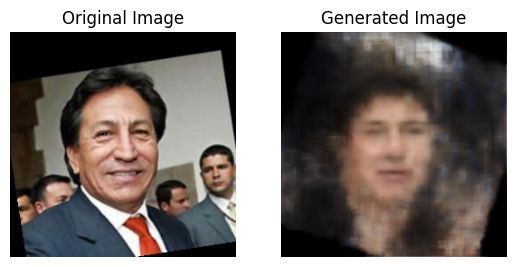

In [102]:
def get_random_image(dataloader):
    random_idx = random.randint(0, len(dataloader) - 1)
    return dataloader.dataset[random_idx][0]

def plot_image(image, title, position):
    plt.subplot(1, 2, position)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

def generate_image(model, device):
    with torch.no_grad():
        sample = torch.randn(1, 20).to(device)
        return model.decode(sample).cpu().squeeze()

# Main code
model.eval()
original_image = get_random_image(dataloader).to(device)
plot_image(original_image, "Original Image", 1)
generated_image = generate_image(model, device)
plot_image(generated_image, "Generated Image", 2)
plt.show()